In [11]:
import math
from functools import partial
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import display, HTML
import logging
logging.basicConfig(level=logging.WARNING)
%matplotlib inline

In [15]:
# Code to animate an environment

def animate(env, im, i):
    # print(f"animate {i}")
    env.proceed(1.0)
    v = env.value.copy()
    im.set_array(v)
    return [im]

def animate_environment(env):
    fig, ax = plt.subplots()
    im  = ax.imshow(env.value, cmap="gray", vmin=0, vmax=1.0)
    anim = animation.FuncAnimation(fig, partial(animate, env, im), 
                                       frames=100, interval=100, 
                                       blit=True)
    return anim

# Environment base classes

The basic abstract classes that model certain kind of environments and their temporal evolution and the way they can be observed.

* Tracks an observable of the environment (eg. temperature). 
* Tracks the available information about the environment. 

In [24]:
class Environment:
    """The ancestor of all environment models: by default it is just an area [0,0, width, height]"""
    def __init__(self, width, height, seed):
        self.width, self.height = width, height
        self.random = np.random.default_rng(seed)
        
    def proceed(self, delta_t = 1.0):
        pass

class ScalarFieldEnvironment(Environment):
    """A static environment which for each point it has a scalar field value. 
    This environment does not change: the dynamic aspect happens in the way it 
    is discovered."""
    
    def __init__(self, name, width, height, seed, value = None):
        super().__init__(width, height, seed)
        self.name = name # the name of the value
        if value != None:
            self.value = value.copy()
        else:
            self.value = np.zeros((self.width, self.height))
        
    def get(self, x, y):
        """Accessing by x and y is rounded to the integer value"""
        i = int(x)
        j = int(y)
        return self.value(i, j)

    def proceed(self, delta_t = 1.0):
        pass

In [62]:
class PollutionModelEnvironment(ScalarFieldEnvironment):
    """An environment which models the appearance and spreading of polution"""
    
    def __init__(self, name, width, height, seed, dissipation_rate = 0.95, 
                 p_pollution = 0.1, pollution_max_strength = 1000, evolve_speed = 1):
        super().__init__(name, width, height, seed) 
        self.evolve_speed = evolve_speed # measured in convolutions / second
        self.p_pollution = p_pollution
        self.pollution_max_strength = pollution_max_strength
        self.dissipation_rate = dissipation_rate
        self.evolve_kernel = np.array([[0.3, 0.5, 0.3],[0.5, 1, 0.5],[0.3, 0.5, 0.3]])
        self.evolve_kernel = self.evolve_kernel * (self.dissipation_rate / self.evolve_kernel.sum())
        
    def proceed(self, delta_t = 1.0):
        """Apply the polution events. Applyies the evolution kernel a number of times 
        determined by the evolve speed"""
        self.pollution_init(delta_t)
        iterations = int(self.evolve_speed * delta_t)
        convspace = np.zeros((self.width * 3, self.height * 3))
        convspace[self.width: self.width *2, self.height: self.height*2] = self.value
        for i in range(iterations):
            convspace = signal.convolve2d(convspace, self.evolve_kernel, mode="same")
        self.value = convspace[self.width: self.width *2, self.height: self.height*2]
        logging.info(f"sum {self.value.sum()}")        
        
    def pollution_init(self, delta_t):
        """One or more new pollution sources appear"""
        val = self.random.random()
        pollution_event_count = int(delta_t * self.p_pollution / val)
        for i in range(0, pollution_event_count):            
            rands = self.random.random(3)
            x = int(rands[0] * self.width-7) # the -7 is due to the way the convolution works
            y = int(rands[1] * self.height-7)            
            #x = self.random.randint(0, self.width-7)
            #y = self.random.randint(0, self.height-7)
            strength = rands[2]
            self.value[x,y]=strength * self.pollution_max_strength

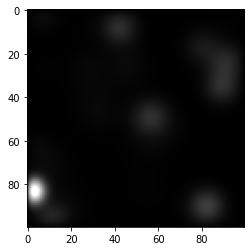

In [63]:
env = PollutionModelEnvironment("water", 100, 100, seed=20, dissipation_rate = 0.95)
#env.evolve_speed = 1
#env.p_pollution = 0.1
#env.pollution_max_strength = 1000
#env.dissipation_rate = 10.5
anim = animate_environment(env)
HTML(anim.to_html5_video())

In [66]:
class EpidemicSpreadEnvironment(ScalarFieldEnvironment):
    """An environment modeling the spreading of an epidemic in the field. The value 
    field is 0 or 1 depending whether the location is currently infected. 
    
    The status field is 0 if not infected, +number if infected with days left, -1 if 
    immune"""
    def __init__(self, name, width, height, seed, p_transmission = 0.2, infection_duration = 5):
        super().__init__(name, width, height, seed)
        self.status = np.zeros((width, height))        
        self.p_transmission = p_transmission 
        self.p_infection = self.calculate_infection_matrix(self.p_transmission)
        self.infection_duration = infection_duration
    
    @staticmethod
    def calculate_infection_matrix(p_transmission): 
        """Calculates a matrix for the probability of the transmission function of the number of
        infected neighbors"""
        pr = np.ones(9) * (1 - p_transmission)
        pows = np.linspace(0, 8, 9)
        p_infection = np.ones(9) - np.power(pr, pows)
        return p_infection
    
    @staticmethod
    def countinfected_neighbor(statusmap):
        """Given a matrix with the status values, returns a matrix with the counts of the 
        infected neighbors"""
        infected = np.zeros(statusmap.shape)
        infected[statusmap > 0] = 1
        neighborcounting_kernel = np.array([[1,1,1], [1, 0, 1], [1, 1, 1]])
        infectedcount = signal.convolve2d(infected, neighborcounting_kernel, mode="same")
        return infectedcount

    def proceed(self, delta_t):
        # make those that finished their sickness immune
        self.status[self.status==1] = -1
        # decrease the time remaining for infection
        self.status[self.status > 0] -= 1
        # propagate the infection
        infectedcount = self.countinfected_neighbor(self.status)
        infectionlikelihood = self.p_infection[infectedcount.astype(int)]
        p = self.random.random(self.status.shape)
        il = infectionlikelihood 
        il[il > p] = 1
        il[il <= p] = 0
        self.status[np.logical_and(self.status== 0, il == 1)] = self.infection_duration
        self.value = np.zeros(self.status.shape)
        self.value[self.status > 0] = 1
        self.value[self.status < 0] = 0.5

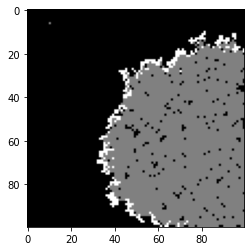

In [72]:
env = EpidemicSpreadEnvironment("crop", 100, 100, seed=40, infection_duration = 5, p_transmission = 0.1)
env.status[6,10] = 2
env.status[60,80] = 5
anim = animate_environment(env)
HTML(anim.to_html5_video())